# <center> Итоговый проект. Бриф “Агентство недвижимости”


## <center> Часть 2. Подбор модели, настройка параметров и подготовка к продакшену

### 0. Импорт библиотек

In [3]:
# стандартные библиотеки
import pandas as pd
import pickle

import sklearn.preprocessing as pp
import sklearn.model_selection as ms 
import sklearn.feature_selection as fs 
import sklearn.metrics as m 

import sklearn.linear_model as lm
import sklearn.tree as t
import sklearn.ensemble as ens
import sklearn.neighbors as knn
import sklearn.pipeline as pl


# для визуализации
import matplotlib.pyplot as plt         
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

RS = 42

### 1. Загрузка данных

In [4]:
X = pd.read_csv('data/data_new.csv')

X

,auction,backup,closed,contigent,foreclosed,inspection,is_active,new,option contract,pre_foreclosure,...,zipcode_2,zipcode_4,zipcode_5,zipcode_6,zipcode_7,zipcode_11,beds,stories,price_sqft,target
0,0,0,0,0,0,0,1,0.0,0,0,...,0,0,0,0,0,0,4,1,144.0,418000
1,0,0,0,0,0,0,1,0.0,0,0,...,0,0,0,0,0,1,3,2,159.0,310000
2,0,0,0,0,0,0,1,0.0,0,0,...,0,0,0,0,0,0,5,3,371.0,2395000
3,0,0,0,0,0,0,1,0.0,0,0,...,0,0,0,0,0,1,2,2,233.0,209000
4,0,0,0,0,0,0,1,0.0,0,0,...,0,0,0,0,0,1,1,1,120.0,181500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
256460,0,0,0,0,0,0,0,0.0,0,0,...,0,0,1,1,1,0,4,1,137.0,252990
256461,0,0,0,0,0,0,1,0.0,0,0,...,0,1,1,1,0,1,2,3,564.0,799000
256462,0,0,0,0,0,0,1,0.0,0,0,...,0,1,0,0,0,1,3,9,337.0,674999
256463,0,0,0,0,0,0,1,0.0,0,0,...,0,1,1,0,1,1,3,2,458.0,528000


### 2. Подготовка данных
> Нужно разделить данные на обучающую и тестовую выборки для дальнейших манипуляций.

In [5]:
# для визуализации при масштабировании отберем небинарные переменные в список
numeric_cols = []

for col in X.columns:
    if X[col].nunique() > 2:
        numeric_cols.append(col) 


numeric_cols

['baths',
 'year_built',
 'remodeled_year',
 'parking_spaces_cnt',
 'population',
 'density',
 'ranking',
 'school_ratings_sum',
 'school_ratings_mean',
 'school_distance_nearest',
 'school_distance_mean',
 'school_grades',
 'area_in_sqft',
 'beds',
 'stories',
 'price_sqft',
 'target']

* #### Разделение данных и масштабирование
> Данные имеют очень разный масштаб значений, так что нам нужно провести их нормализацию. Так как данные уже очищены от выбросов, и у нас много бинарный признаков, то лучше всего подойдет *MinMaxScaler*.

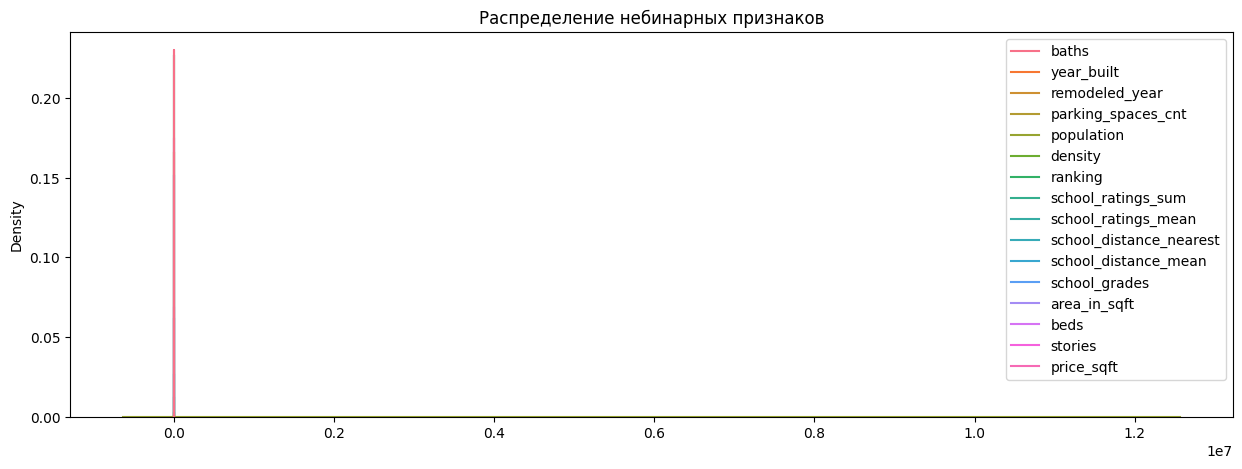

In [6]:
y = X.pop('target')

X_train, X_test, y_train, y_test = ms.train_test_split(
    X, y, test_size=0.2, random_state=RS
)

numeric_cols.remove('target')

plt.figure(figsize=(15, 5))
sns.kdeplot(X_train[numeric_cols])

plt.title('Распределение небинарных признаков')
plt.show()

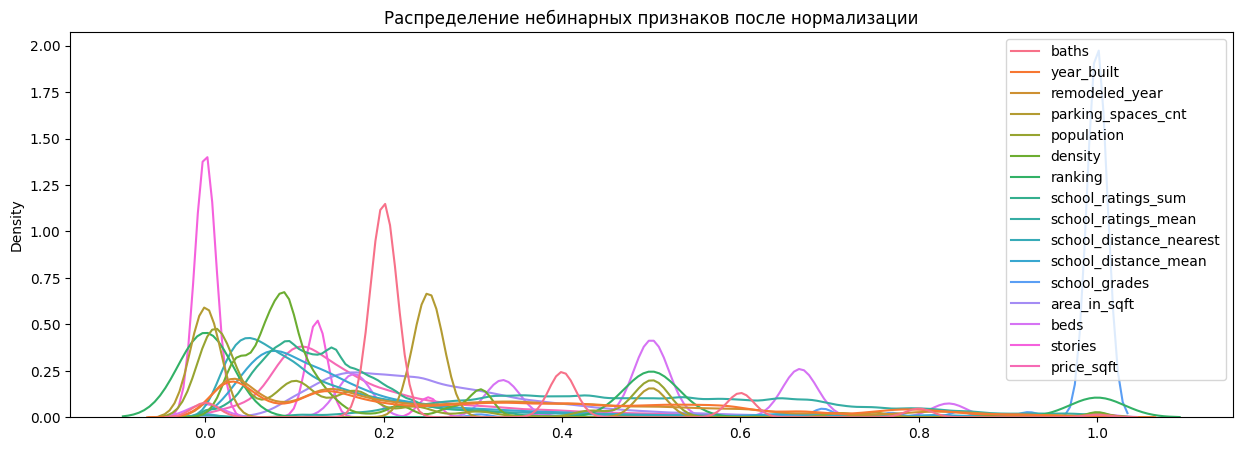

In [7]:
scaler = pp.MinMaxScaler(copy=False)
scaler.fit(X_train)

# заносим новые данные в датафреймы
X_train = pd.DataFrame(
    scaler.transform(X_train), 
    columns = X.columns
)
X_test = pd.DataFrame(
    scaler.transform(X_test), 
    columns = X.columns
)


plt.figure(figsize=(15, 5))
sns.kdeplot(X_train[numeric_cols])

plt.title('Распределение небинарных признаков после нормализации')
plt.show()

> Теперь распределения выглядят куда лучше. Кстати, легенда хоть и мешает разглядеть, но можно увидеть, что признак *school_grades* сконцентрирован на отметке 1, потому что как мы помним подавляющее большинство школ предоставляют полное образование с детского сада по 12 класс.

* #### Отбор признаков
> Мы имеем свыше 70 переменных, далеко не все из них будут полезны да и обучение будет дольше. Поэтому отберем из них, скажем, 30 лучших.

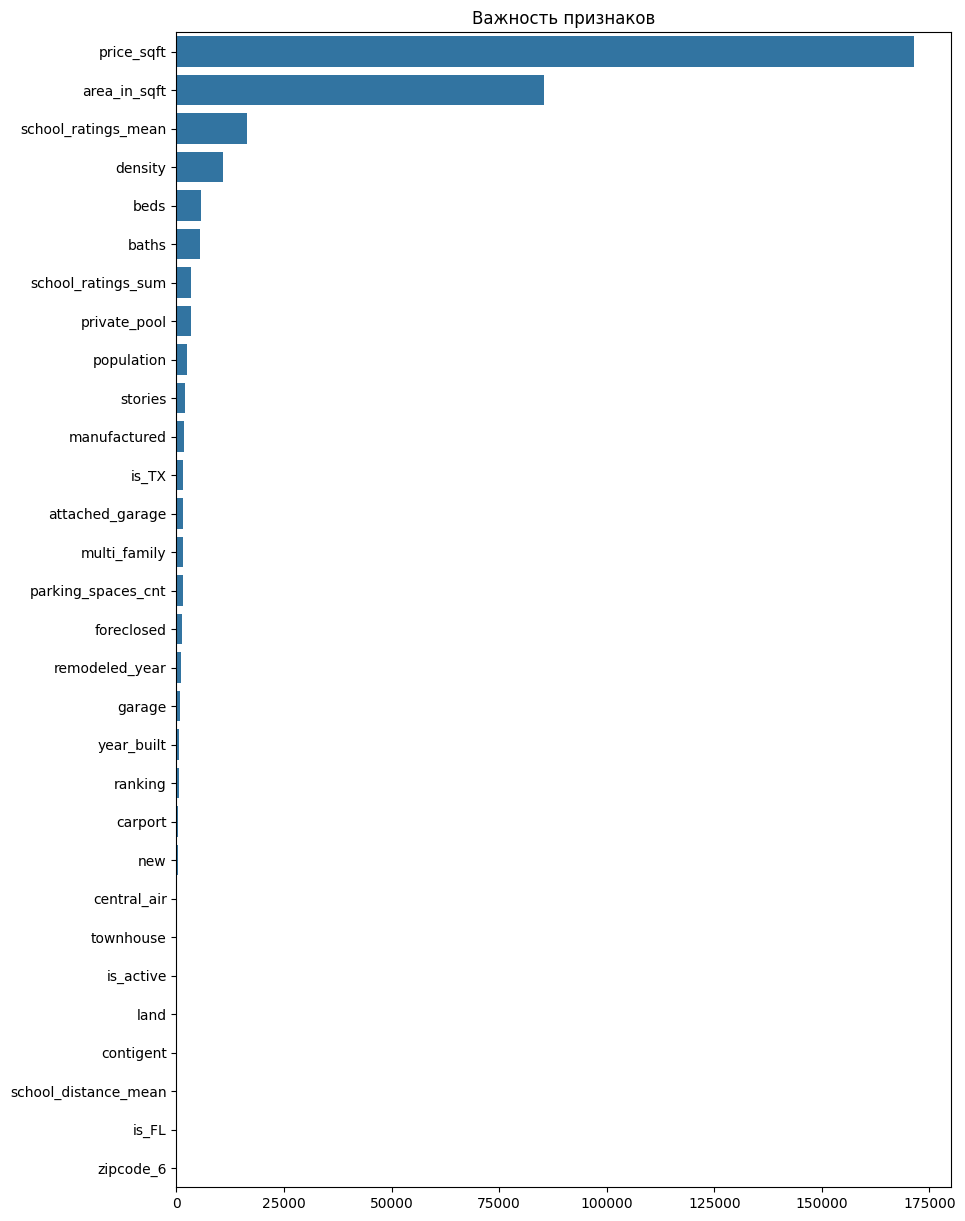

In [8]:
selector = fs.SelectKBest(score_func=fs.f_regression, k=30)
selector.fit(X_train, y_train)

best_cols = selector.get_feature_names_out()

X_train = X_train[best_cols]
X_test = X_test[best_cols]


# создадим чарт самых влиятельных признаков
features_scores = pd.Series(selector.scores_, index=selector.feature_names_in_)

plt.figure(figsize=(10, 15))
sns.barplot(features_scores[best_cols].sort_values(ascending=False), orient='h')

plt.title('Важность признаков')
plt.show()

> Как и предполагалось, в самом верху оказались признаки, которые сильнее всего коррелируют с целевой переменной. 

### 3. Моделирование
> Проведем перебор различных моделей и посмотрим, какие из них лучше всего по метрикам. В качестве таковых я возьму 
- *корень из среднеквадратичной ошибки*; 
- *среднюю абсолютную ошибку*; 
- *среднюю абсолютную ошибку в процентах*;
- *коэффициент R2*.

In [9]:
def regression_metrics(estimator):
    estimator.fit(X_train, y_train)
    y_pred_train = estimator.predict(X_train)
    y_pred_test = estimator.predict(X_test)
    
    metric_df = pd.DataFrame(index=['RMSE', 'MAE', 'MAPE', 'R2'], columns=['Train', 'Test'])
    
    metric_df.loc['RMSE', 'Train'] = m.mean_squared_error(y_train, y_pred_train, squared=False)
    metric_df.loc['MAE', 'Train'] = m.mean_absolute_error(y_train, y_pred_train)
    metric_df.loc['MAPE', 'Train'] = m.mean_absolute_percentage_error(y_train, y_pred_train)
    metric_df.loc['R2', 'Train'] = m.r2_score(y_train, y_pred_train)
    
    metric_df.loc['RMSE', 'Test'] = m.mean_squared_error(y_test, y_pred_test, squared=False)
    metric_df.loc['MAE', 'Test'] = m.mean_absolute_error(y_test, y_pred_test)
    metric_df.loc['MAPE', 'Test'] = m.mean_absolute_percentage_error(y_test, y_pred_test)
    metric_df.loc['R2', 'Test'] = m.r2_score(y_test, y_pred_test)
    
    return metric_df

In [10]:
regression_metrics(lm.LinearRegression())

,Train,Test
RMSE,150295.510143,151934.720324
MAE,90346.764737,90946.236604
MAPE,0.919424,0.887353
R2,0.844578,0.843108


In [11]:
regression_metrics(lm.SGDRegressor(random_state=RS))

,Train,Test
RMSE,150341.898873,151984.379446
MAE,90188.787041,90791.256283
MAPE,0.916186,0.854456
R2,0.844482,0.843005


In [12]:
regression_metrics(lm.PassiveAggressiveRegressor(random_state=RS))

,Train,Test
RMSE,160832.431061,162155.286
MAE,82696.149101,82891.316289
MAPE,0.756826,1.309194
R2,0.822021,0.82129


In [13]:
regression_metrics(t.DecisionTreeRegressor(random_state=RS)) 

,Train,Test
RMSE,659.890512,24402.461618
MAE,2.739801,3181.39018
MAPE,0.000005,0.027644
R2,0.999997,0.995953


In [14]:
regression_metrics(ens.RandomForestRegressor(random_state=RS))

,Train,Test
RMSE,5901.413108,18964.604619
MAE,746.763303,2024.97988
MAPE,0.062843,0.11197
R2,0.99976,0.997556


In [15]:
regression_metrics(ens.GradientBoostingRegressor(random_state=RS))

,Train,Test
RMSE,26514.377711,27592.278698
MAE,13012.958141,13152.993333
MAPE,0.289356,0.583853
R2,0.995163,0.994826


In [16]:
regression_metrics(ens.ExtraTreesRegressor(random_state=RS)) 

,Train,Test
RMSE,659.897736,18523.444829
MAE,2.760213,1896.130299
MAPE,0.000005,0.378309
R2,0.999997,0.997668


In [17]:
regression_metrics(knn.KNeighborsRegressor()) 

,Train,Test
RMSE,143560.011164,182716.442028
MAE,79037.352428,99923.672435
MAPE,0.978933,3.849194
R2,0.858196,0.773096


> Лучше всего из рассмотренных моделей справился случайный лес, он показвает наименьшие ошибки, но поскольку параметры выставлены по умолчанию, он переобучился. Попробуем его настроить. За метрику возьму *RMSE*.

In [18]:
model = ens.RandomForestRegressor(random_state=RS)

# создадим датафрейм, куда будем заносить ошибку на той или иной глубине дерева
errors_df = pd.DataFrame(columns=['Train', 'Test'])

for depth in range(1, 11):
    model.set_params(max_depth=depth)
    model.fit(X_train, y_train)
    
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    errors_df.loc[depth, 'Train'] = m.mean_squared_error(y_train, y_pred_train, squared=False)
    errors_df.loc[depth, 'Test'] = m.mean_squared_error(y_test, y_pred_test, squared=False)

    print(f'Random forest with max_depth={depth} has been fitted')

Random forest with max_depth=1 has been fitted
Random forest with max_depth=2 has been fitted
Random forest with max_depth=3 has been fitted
Random forest with max_depth=4 has been fitted
Random forest with max_depth=5 has been fitted
Random forest with max_depth=6 has been fitted
Random forest with max_depth=7 has been fitted
Random forest with max_depth=8 has been fitted
Random forest with max_depth=9 has been fitted
Random forest with max_depth=10 has been fitted


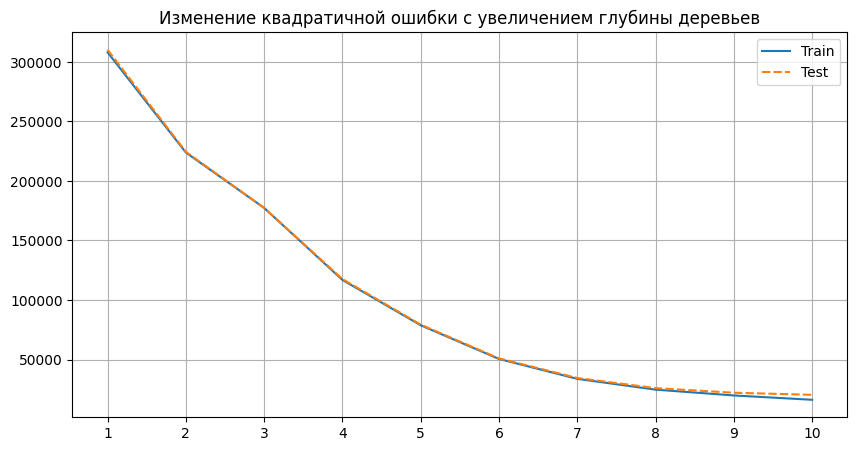

In [19]:
# визуализуем полученные результаты
plt.figure(figsize=(10, 5))
sns.lineplot(errors_df)
    
plt.xticks(range(1, 11))
plt.title('Изменение квадратичной ошибки c увеличением глубины деревьев')
plt.grid()
plt.legend()

plt.show()

> На мой взгляд, лучшим значением для максимальной глубины дерева - это 9, поскольку ошибки на нем ниже, чем на отметке 8, но и они не так сильно расходятся, как на отметке 10.

In [20]:
# посмотрим, какие метрики имеет наша модель
model = ens.RandomForestRegressor(max_depth=9, random_state=RS)

regression_metrics(model)

,Train,Test
RMSE,19838.40095,22129.894292
MAE,7839.262568,8074.447567
MAPE,0.162558,0.14387
R2,0.997292,0.996672


In [21]:
# какова абсолютная разница между ошибками на обучающей и тестовой выборках?
errors_diff = errors_df['Train'].sub(errors_df['Test']).abs().loc[9]

errors_diff

2291.49334155058

> Я думаю, мы имеем вполне приемлемый результат, тем более если посмотреть например на *MAPE*, то предсказания модели отличаются от средней цены на меньше чем четверть процента, а показатели *R2* очень близки к 1.

* #### Сохранение модели в пайплайн
> Для того чтоб реализовать нашу модель в сервисе, то она должна будет принимать уже обработанные данные, поэтому нужно создать такой алгоритм этой обработки, который будет включать в себя:
- Масштабирование
- Отбор признаков
- Предсказание цены на недвижимость

In [22]:
realty_pipeline = pl.Pipeline([
    ('scaler', scaler), 
    ('selector', selector), 
    ('model', model)
    ]).fit(X_train, y_train)

# сохраняем его в сериализованном виде
with open('app/models/realty_pipeline.pkl', 'wb') as pkl_f:
    pickle.dump(realty_pipeline, pkl_f)

In [23]:
# проверяем, все ли прошло корректно
with open('app/models/realty_pipeline.pkl', 'rb') as pl_f:
    pl_from_bytes = pickle.load(pl_f)
    
print(pl_from_bytes)

Pipeline(steps=[('scaler', MinMaxScaler(copy=False)),
                ('selector',
                 SelectKBest(k=30,
                             score_func=<function f_regression at 0x0000014C54C75C60>)),
                ('model', RandomForestRegressor(max_depth=9, random_state=42))])


> Мы смогли создать и настроить модель, теперь ее можно будет внедрять в сервис по предсказанию цен.